<a href="https://colab.research.google.com/github/Jinwooseol/Deep-learning/blob/main/Deep_Learning_%ED%95%99%EC%8A%B5_%EA%B8%B0%EC%88%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#딥러닝 학습 기술
- Optimization (매개변수 갱신)  
  - 확률적 경사하강법, 모멘텀, AdaGrad, Adam
- Weight Decay
- Batch Normalization
- Overfitting / Underfitting
- Regularization
- Drop Out
- Hyper parameter  
  - Learning Rate, Epochs, Size of mini_batch

#Optimization: 매개변수 갱신

**확률적 경사하강법 (Stochastic Gradient Descent, SGD)**
- 전체를 한번에 계산하지 않고, **확률적**으로 일부 샘플을 뽑아 나누어 학습시키는 과정

  **장점**
- 반복할 때마다 처리하는 데이터의 수가 적기 때문에 한 번 처리하는 속도가 빠름
- 한 번 학습할 때 필요한 메모리만 있으면 되므로 매우 큰 데이터셋에 대해서도 학습이 가능

  **단점**
- 확률적이기 때문에, 배치 경사하강법보다 불안정
- 손실함수의 최솟값 (최적값)에 이를 때까지 요동치면서 이동  

- 따라서, 위와 같은 문제로 인해 **미니 배치 경사하강법(mini-batch gradient descent)**으로 학습을 진행
- 최근에는 SGD라고하면 일반적으로 mini-batch gradient descent를 의미함

> $W ← W - 𝛾\frac{∂L}{∂W}$  
> ($𝛾$: Learning Rate)

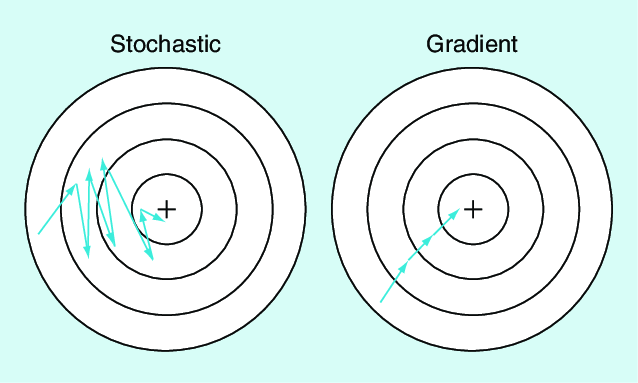

Reference: Carpenter, Kristy & Cohen, David & Jarrell, Juliet & Huang, Xudong. (2018). Deep learning and virtual drug screening. Future Medicinal Chemistry. 10. 10.4155/fmc-2018-0314. 

In [62]:
class SGD:
  
  def __init__(self, learning_rate=0.01):
    self.learning_rate = learning_rate

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.learning_rate * grads[key]


In [ ]:
optimizer = SGD()

#for i in range(10000):
  #optimizer.update(params, grads)

#SGD의 단점
- 단순하지만, 문제에 따라서 시간이 매우 오래걸림

#모멘텀 (Momentum)
- 운동량을 의미 (관성과 관련)
- 공이 그릇의 경사면을 따라서 내려가는 듯한 모습
- 이전의 속도를 유지하려는 성향 (관성) -> 경사하강을 더 유지하려는 성격을 지님
- 단순히 SGD만 사용하는 것보다 적게 방향이 변함

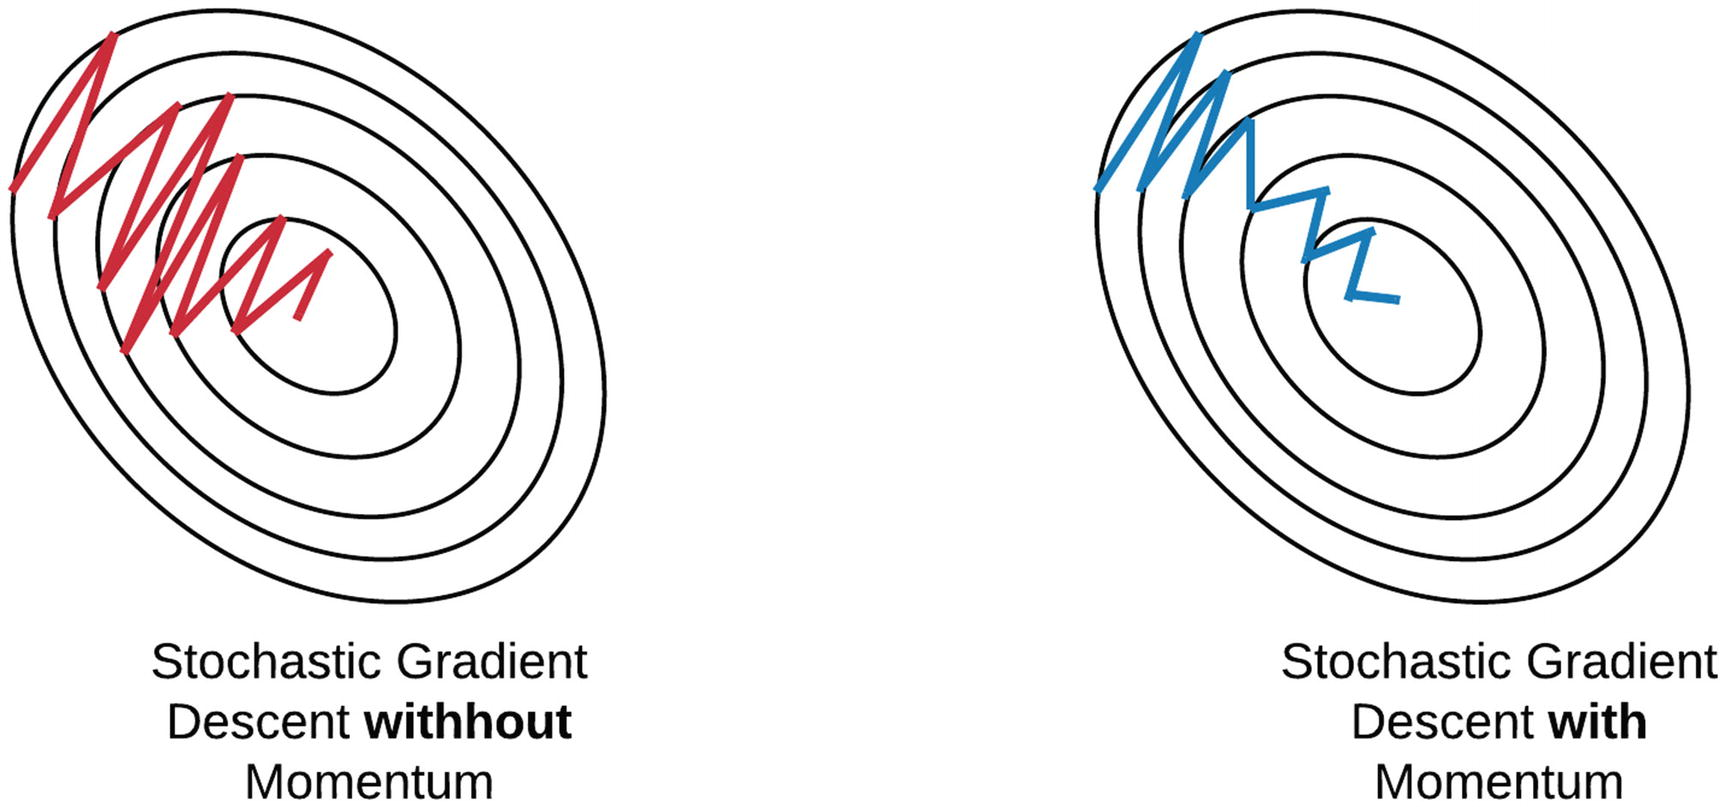

Reference:  https://link.springer.com/chapter/10.1007/978-1-4842-4470-8_33

> $v ← αv - 𝛾\frac{∂L}{∂W}$  
$W ← W + v$  
- $α$: 관성계수  
- $v$: 속도  
- $𝛾$: 학습률  
- $\frac{∂L}{∂W}$: 손실함수에 대한 미분값

In [1]:
import numpy as np

class Momentum:

  def __init__(self, learning_rate=0.01, momentum=0.9):
    self.learning_rate = learning_rate
    self.momentum = momentum
    self.v = None

  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)

      for key in params.keys():
        self.v[key] = self.momentum * self.v[key] - self.learning_rate * grads[key]
        params[key] += self.v[key]

#AdaGrad (Adaptive Gradient)
- 가장 가파른 경사를 따라 빠르게 하강하는 방법
- **적응적 학습률**이라고도 함 (학습률을 변화시키며 진행)  
  - 경사가 급할 때는 빠르게 변화, 완만할 때는 느리게 변화
- 간단한 문제에서는 좋을 수 있지만 Deep Learning에서는 자주 쓰이지 않음  
  ($\because$ 학습률이 너무 감소되어 전역최소값(Global minimum)에 도달하기 전에 학습이 종료될 수 있기 때문에)

> $h ← h + \frac{∂L}{∂W} ⊙ \frac{∂L}{∂W}$  

> $W ← W + 𝛾\frac{1}{\sqrt{h + ϵ}}\frac{∂L}{∂W}$  

- $h$: 기존 기울기를 제곱하여 더한 값
- $𝛾$: 학습률  
- $\frac{∂L}{∂W}$: 손실함수에 대한 미분값
- $ϵ$: 굉장히 작은 수 (h가 0일 때를 방지하기 위하여)



In [3]:
class AdaGrad:

  def __init__(self, learning_rate=0.01):
    self.learning_rate = learning_rate
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

      for key in params.keys():
        self.h[key] += grads[key] * grads[key]
        params[key] += self.learning_rate * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#RMSProp (Root Mean Square Propagation)
- AdaGrad를 보완하기 위한 방법
- 합 대신 지수의 평균값을 활용
- 학습이 안되기 시작하면 학습률을 증가시키고, 학습률이 너무 크면 학습률을 다시 감소

> $h ← 𝜌h + (1 - 𝜌)\frac{∂L}{∂W} ⊙ \frac{∂L}{∂W}$  

> $W ← W + 𝛾\frac{∂L}{∂W}/ ~ \sqrt{h + ϵ}$  

- $h$: 기존 기울기에서 보정된 값
- $𝜌$: Decay Rate (지수 평균의 업데이트 계수)
- $𝛾$: 학습률  
- $\frac{∂L}{∂W}$: 손실함수에 대한 미분값


In [4]:
class RMSProp:

  def __init__(self, learning_rate=0.01, decay_rate=0.99):
    self.learning_rate = learning_rate
    self.decay_rate = decay_rate
    self.h = None

  def update(self, params, grads):
    if self.h is None:
      self.h = {}
      for key, val in params.items():
        self.h[key] = np.zeros_like(val)

      for key in params.keys():
        self.h[key] *= self.decay_rate
        self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
        params[key] -= self.learning_rate * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


#Adam (Adaptive Moment Estimation)
- 모멘텀 최적화와 RMSProp의 아이디어를 합친 것
- 지난 gradient의 지수 감소 평균을 따르고 (Momentum), 지난 gradient 제곱의 지수 감소된 평균 (RMSProp)을 따름
- 가장 많이 사용되는 최적화 방법

> $t ← t + 1$  
$m_t ← β_1 m_{t-1} - (1 - β_1) \frac{∂L}{∂W}$  
$v_t ← β_2 v_{t-1} - (1 - β_2) \frac{∂L}{∂W} ⊙\frac{∂L}{∂W}$  
$\hat{m_t} ← \frac{m_t}{1-β_1^t}$  
$\hat{v_t} ← \frac{v_t}{1-β_2^t}$  
$W_t ← W_{t-1} + 𝛾~\hat{m_t}/\sqrt{\hat{v_t} + ϵ}$

- $β$: 지수 평균의 업데이트 계수
  ($\beta_{1} \approx 0.9, \beta_{2} \approx 0.999$)
- $𝛾$: 학습률  
- $\frac{∂L}{∂W}$: 손실함수에 대한 미분값

In [22]:
class Adam:

  def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999):
    self.learning_rate = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None

  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = {}, {}
      for key, val in params.items():
        self.m[key] = np.zeros_like(val)
        self.v[key] = np.zeros_like(val)

    self.iter += 1
    learning_rate_t = self.learning_rate * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

    for key in params.keys():
      self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
      self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])

      params[key] -= learning_rate_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

#최적화 방법 비교 (Ex. Linear Regression)
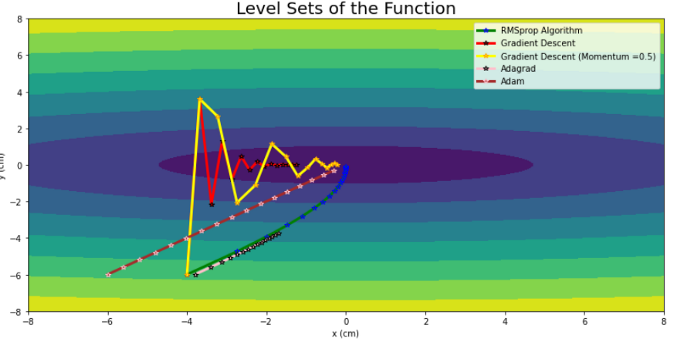

Reference: https://towardsdatascience.com/comparative-performance-of-deep-learning-optimization-algorithms-using-numpy-24ce25c2f5e2

#가중치 소실 (Gradient Vanishing)
- AI 두 번째 위기
- 활성화함수가 Sigmoid 함수 일 때, 은닉층의 개수가 늘어 날수록 가중치가 역전파되면서 가중치 소실문제 발생  
  - 0 ~ 1 사이의 값으로 출력되면서 0 또는 1에 가충치 값이 퍼짐  
    (이는 미분값이 점점 0에 가까워짐을 의미)

- 가중치 초기화 문제(은닉층의 활성화값 분포)  
  - 가중치의 값이 일부 값으로 편향되면,
    활성화 함수를 통과한 값이 편향되고, 표현할 수 있는 신경망의 수가 작아짐

- 따라서, **활성화값이 골고루 분포되는 것이 중요!**
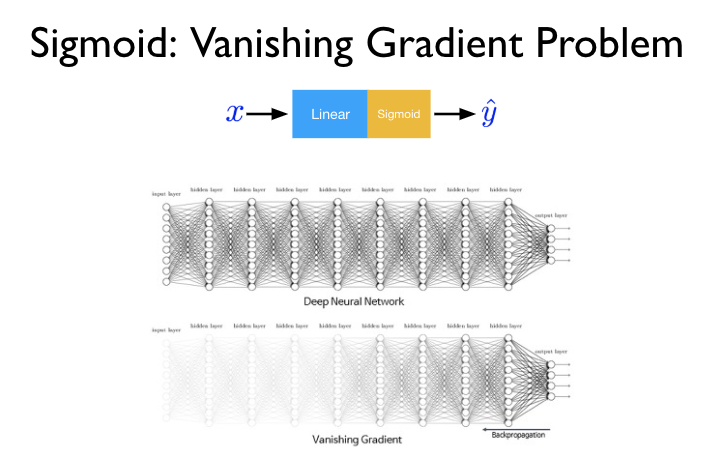

Reference: https://www.kaggle.com/getting-started/118228

#가중치 초기화
- https://www.deeplearning.ai/ai-notes/initialization/

#초기값 0 (zeros)
- 학습이 올바르게 진행되지 않음
- 오차역전파법에서 모든 가중치의 값이 똑같이 갱신

In [6]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.zeros((nodes, nodes))
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

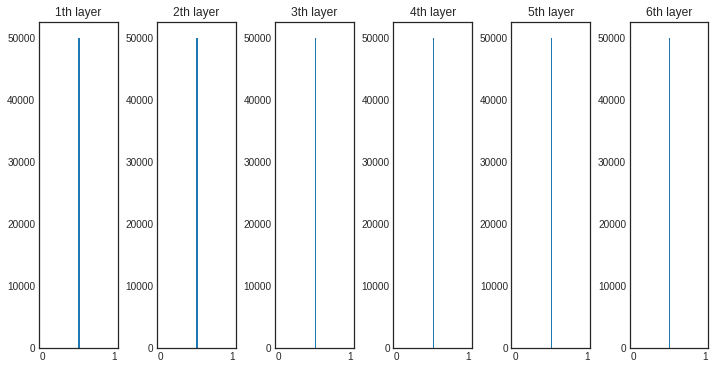

In [10]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: 균일분포 (Uniform)
- 활성화 값이 균일하지 않음 (활성화 함수: Sigmoid)
- 역전파로 전해지는 기울기값이 사라짐

In [16]:
x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.uniform(1, 10, (nodes, nodes))
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

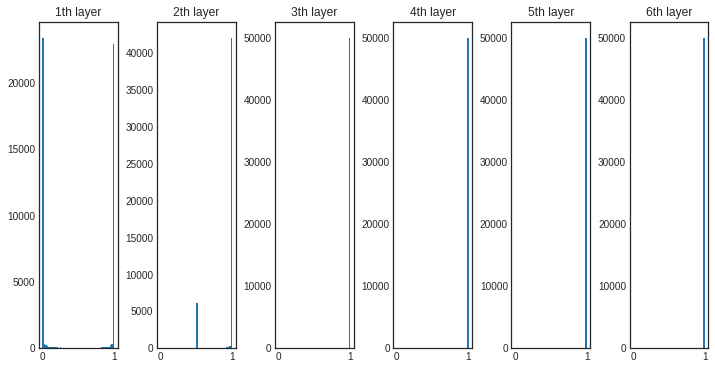

In [12]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: 정규분포 (Nomalization)
- 활성화 함수를 통과하면 양쪽으로 퍼짐
- 0과 1에 퍼지면서 Gradient vanishing 발생

In [14]:
x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes)
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

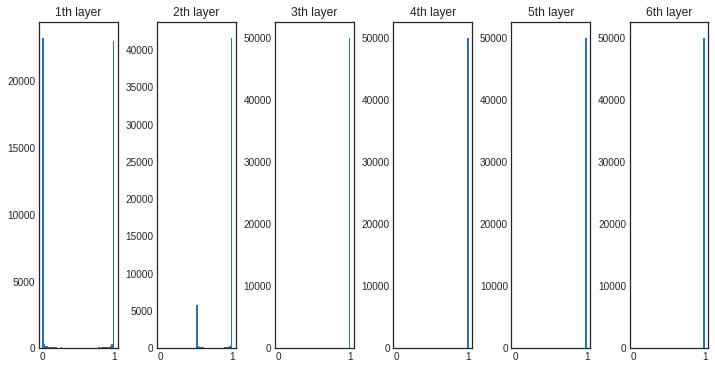

In [17]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#아주 작은 정규분포값으로 가중치 초기화
- 0과 1로 퍼지지 않고, 한쪽으로 편향
- 해당 신경망이 표현할 수 있는 문제가 제한됨

In [19]:
x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) * 0.01 # 가중치 초기화
  a = np.dot(x, w)
  z = sigmoid(a)
  activation_values[i] = z

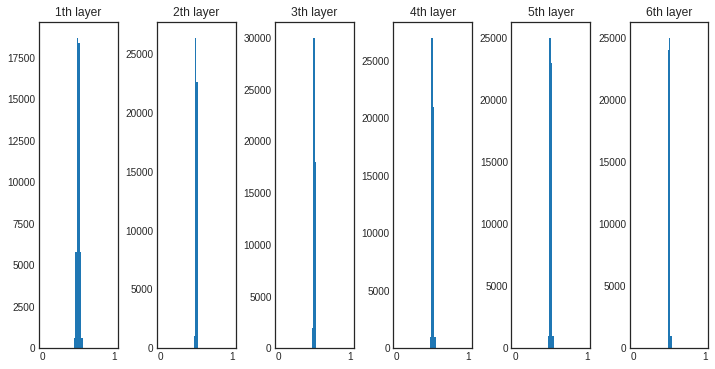

In [20]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: Xavier (Glorot)
- 은닉층의 노드의 수가 n이라면 표준편차가 $\frac{1}{\sqrt{n}}$인 분포
- 더 많은 가중치에 역전파가 전달 가능하고, 비교적 많은 문제를 표현할 수 있음
- 활성화 함수가 **선형**인 함수일 때 매우 적합!

In [26]:
x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) / np.sqrt(nodes) # 가중치 초기화 (Xavier)
  a = np.dot(x, w)
  z = sigmoid(a) # activation function: Sigmoid
  activation_values[i] = z

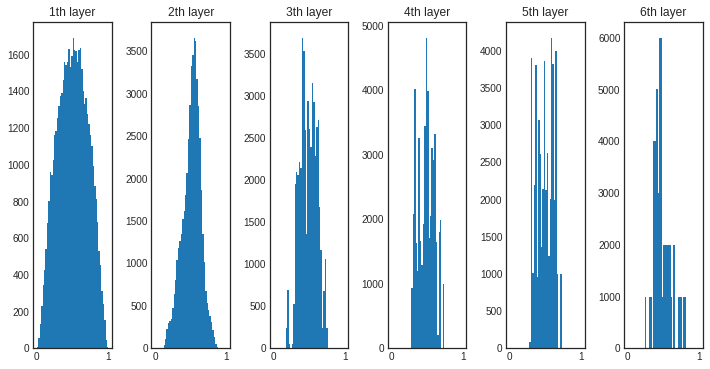

In [27]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: Xavier (Glorot) with tanh function
- 활성화 함수: tanh
- Sigmoid 함수보다 더 깔끔한 분포를 얻을 수 있음

In [30]:
def tanh(x):
  return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) / np.sqrt(nodes) # 가중치 초기화 (Xavier)
  a = np.dot(x, w)
  z = tanh(a) # activation function: Sigmoid
  activation_values[i] = z

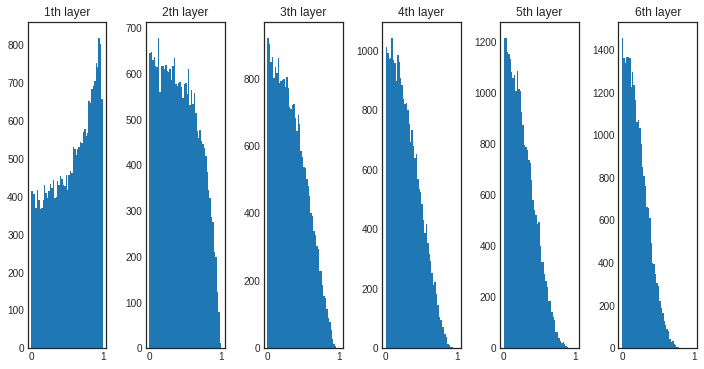

In [31]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#비선형 함수에서의 가중치 초기화

#초기값: 0 (Zeros)
- 활성화 함수: ReLU

In [40]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.zeros((nodes, nodes))
  a = np.dot(x, w)
  z = ReLU(a) # activation function: ReLU
  activation_values[i] = z

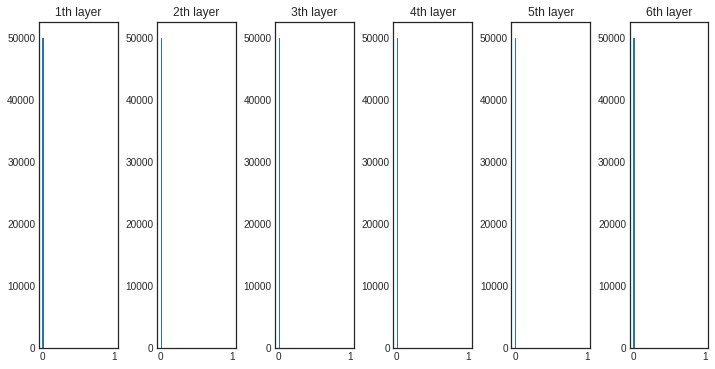

In [34]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: 정규분포 (Normalization)
- 활성화 함수: ReLU

In [37]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes)
  a = np.dot(x, w)
  z = ReLU(a) # activation function: ReLU

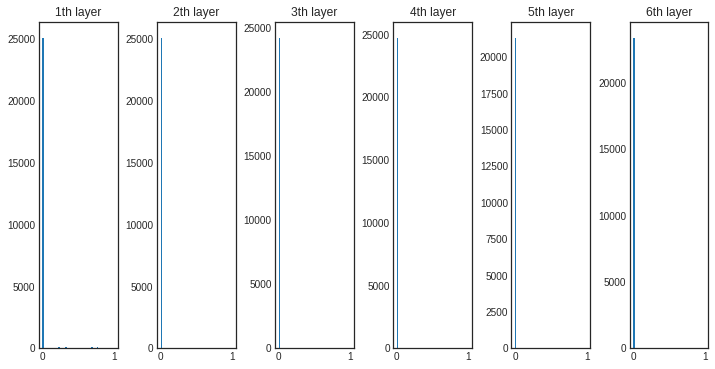

In [38]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#표준편차 0.01

In [42]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) * 0.01 # 표준편차: 0.01
  a = np.dot(x, w)
  z = ReLU(a) # activation function: ReLU
  activation_values[i] = z

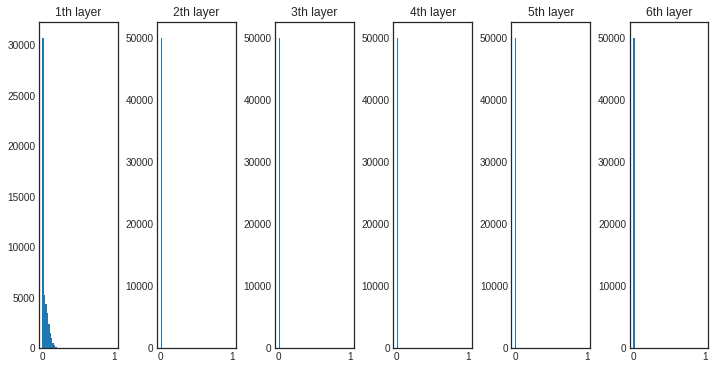

In [43]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: Xavier (Glorot)
- 활성화 함수: ReLU

In [45]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) / np.sqrt(nodes) # 표준편차: 0.01
  a = np.dot(x, w)
  z = ReLU(a) # activation function: ReLU
  activation_values[i] = z

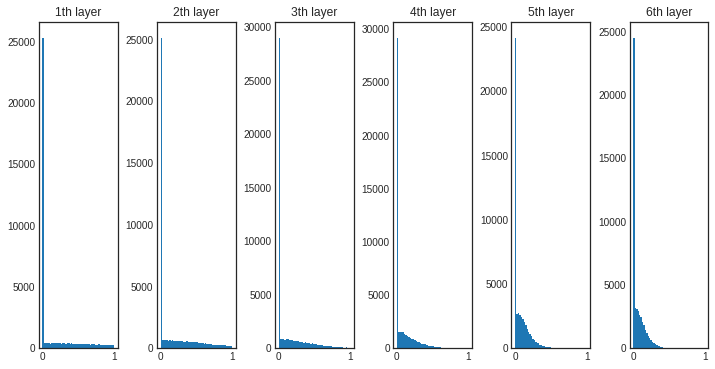

In [46]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#초기값: He
- 표준편차가 $\sqrt{\frac{2}{n}}$인 분포
- 활성화값 분포가 균일하게 분포
- 활성화 함수가 ReLU와 같은 **비선형** 함수 일 떄, 더 적합

In [48]:
def ReLU(x):
  return np.maximum(0, x)

x = np.random.randn(1000, 50)
nodes = 50
hidden_layers = 6
activation_values = {}  # activation function 결과값들

for i in range(hidden_layers):
  if i != 0:
    x = activation_values[i-1]

  w = np.random.randn(nodes, nodes) * np.sqrt(2 / nodes) # 표준편차: 0.01
  a = np.dot(x, w)
  z = ReLU(a) # activation function: ReLU
  activation_values[i] = z

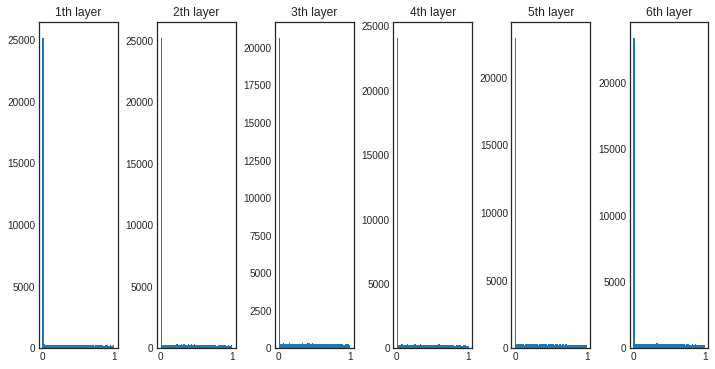

In [49]:
plt.figure(figsize=(12, 6))
for i, a in activation_values.items():
  plt.subplot(1, len(activation_values), i+1)
  plt.title(str(i+1) + 'th layer')
  plt.hist(a.flatten(), 50, range=(0, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

#배치 정규화 (Batch Normalization)
- 가중치의 활성화값이 적당히 퍼지도록 **강제**로 적용
- 미니배치 단위로 데이터의 평균이 0, 표준편차가 1로 정규화
- 학습을 빨리 진행할 수 있음
- 초기값에 크게 의존하지 않음
- 과적합 (Over-fitting) 방지
- 보통 Fully-Connected와 활성화 함수 (비선형) 사이에 놓임

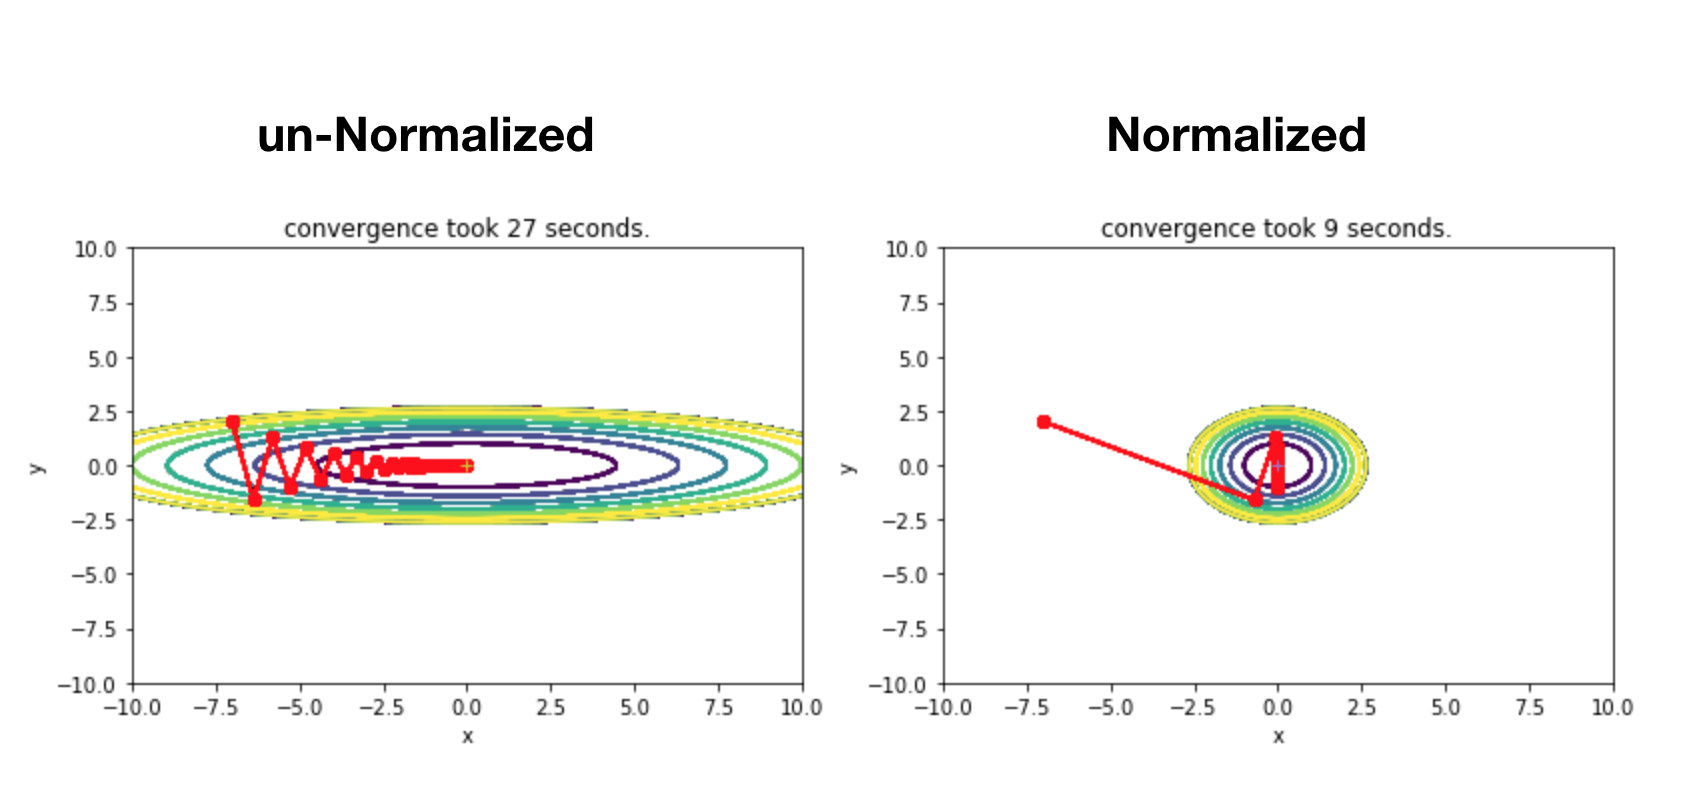


Reference: https://jsideas.net/batch_normalization/

In [51]:
class Batch_Normalization:

  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.running_mean = running_mean
    self.running_var = running_var

    self.input_shape = None
    self.batch_size = None
    self.xc = None
    self.xn = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, input_data, is_train=True):
    self.input_shape = input_data.input_shape
    if input_data.ndim != 2:
      N, C, H, W = input_data.input_shape
      input_data = input_data.reshape(N, -1)

    out = self.__forward(input_data, is_train)

    return out.reshape(*self.input_shape)

  def __forward(self, input_data, is_train):
    if self.running_mean is None:
      N, D = input_data.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    if is_train:
      mu = input_data.mean(axis=0)
      xc = input_data - mu
      var = np.mean(xc**2, axis=0)
      std = np.sqrt(var + 10e-7)
      xn = xc / std

      self.batch_size = input_data.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std
      self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
      self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
    
    else:
      xc = input_data - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
    return out

  def backward(self, dout):
    if dout.ndim != 2:
      N, C, H, W = dout.shape
      dout = dout.reshape(N, -1)

    dx = self.__backward(dout)

    dx = dx.reshape(*self.input_shape)
    return dx
  
  def __backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.sc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx


#과대적합 (Overfitting) / 과소적합 (Underfitting)
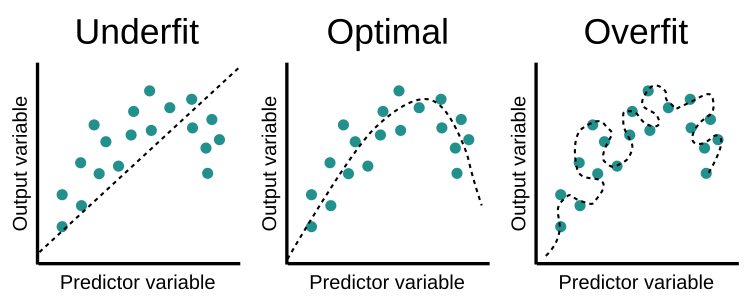

Reference: https://www.educative.io/edpresso/overfitting-and-underfitting

#과대적합 (Overfitting)
- 모델이 학습 데이터에 한에서만 좋은 성능을 보이고 새로운 데이터에 대해서는 그렇지 못한 경우
- 학습 데이터가 매우 적을 경우
- 모델이 지나치게 복잡한 경우
- 학습 횟수가 너무 많을 경우

$~$

**해결방안**
- 학습 데이터를 다양하게 수집
- 모델의 단순화  
  - 파라미터가 적은 모델을 선택하거나, 학습 데이터의 특성 수를 줄임

- 정규화를 통한 규칙의 단순화
- 적절한 hyper parameter 찾기

#과소적합 (Underfitting)
- 학습 데이터를 충분히 학습하지 않아 성능이 매우 안 좋은 경우
- 모델이 지나치게 단순한 경우

$~$
**해결방안**
- 충분한 학습 데이터 수집
- 더 복잡한 모델 사용
- Epochs를 늘려 충분히 학습

#Regularization - 가중치 감소
- Overfitting을 방지하는 방법 중 하나
- Overfitting은 가중치의 매개변수 값이 커서 발생하는 경우가 많음  
  이를 방지하기 위해 **큰 가중치 값에 큰 규제를 가하는 방법**

- 규제란 가중치의 절댓값을 가능한 작게 만드는 것  
  $→$ 가중치의 모든 원소를 0에 가깝게 만들어 모든 특성이 출력에 주는 영향을 최소화하는 것을 의미

- 적절한 규제값을 찾는 것이 중요!

$~$
#L2 Regularization
- 가중치의 제곱
- 손실 함수일정 값을 더함으로써 과적합을 방지
- $λ$값이 크면 가중치 감소가 커지고,  
  $λ$값이 작으면 가중치 감소가 작아진다.
  
> $Cost = \frac{1}{n}\sum_{n}^{i=1}L(y_i, \hat{y_i}) + \frac{\lambda}{2}w^2$  
  $L(y_i, \hat{y_i})$: 기존 Cost Function

#L1 Regularization
- 가중치의 절대값 합
- L2 regularization와 달리 어떤 가중치는 0이 되는데, 이는 모델이 가벼워짐을 의미

> $Cost = \frac{1}{n}\sum_{n}^{i=1}L(y_i, \hat{y_i}) + \frac{\lambda}{2}\left| w\right|$  
  $L(y_i, \hat{y_i})$: 기존 Cost Function

#Dropout
- 과적합을 방지하기 위한 방법
- 학습할 때 **일부의 노드**만을 사용
- 보통 ratio_value는 0.5 or 0.7

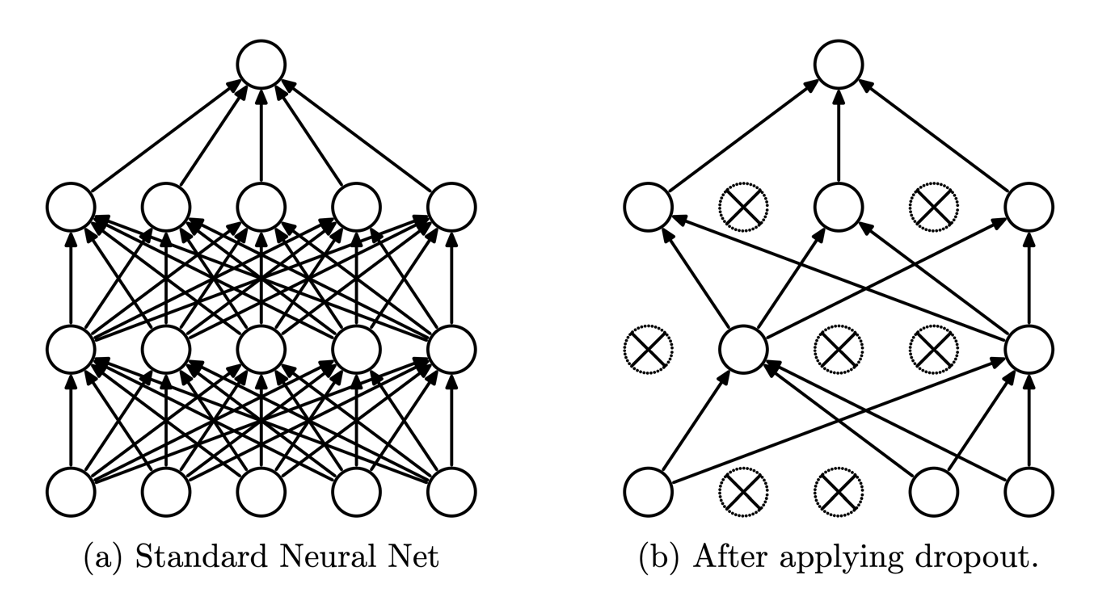

Reference: https://jmlr.org/papers/v15/srivastava14a.html

In [1]:
class Dropout:

  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, input_data, is_train=True):
    if is_train:
      self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
      return input_data * self.mask

    else:
      return input_data * (1.0 - self.dropout_ratio)
  
  def backward(self, dout):
    return dout * self.mask

#Hyper Parameter

>학습률 (Learning Rate)  
- 학습속도 결정

$~$
>학습 횟수 (Epochs)
- 너무 작게, 또는 너무 크게 지정하면 과소적합 또는 과대적합 문제가 발생

$~$
> 미니배치 크기 (Mini Batch Size)
- 미니 배치 학습  
  - 한번 학습할 때 메모리 부족현상을 막기 위해 전체 데이터의 일부를 여러번 학습하는 방식

- 한번 학습할 때마다 얼마만큼의 미니배치 크기를 학습할지 결정
- 배치 크기가 클수록 학습 시간이 적게 소요

$~$
>검증데이터 (Validation Data)
- 주어진 데이터를 학습 + 검증 + 테스트 데이터로 구분하여 과적합을 방지
- 일반적으로 전체의 2~30%를 테스트 데이터,  
  나머지에서 20%정도를 검증용 데이터,  
  남은 부분을 학습용 데이터로 사용

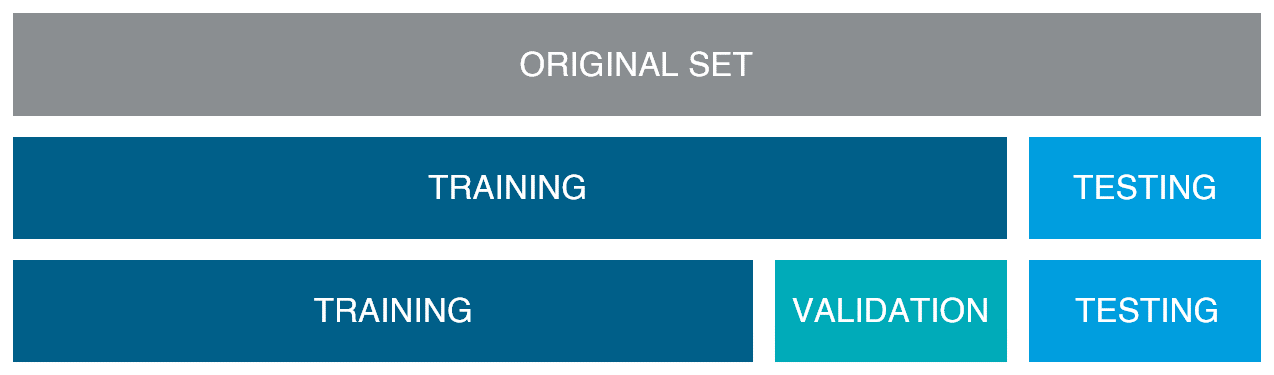

Reference: https://modern-manual.tistory.com/19

#MNIST 분류

In [1]:
#Modules Import
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

plt.style.use('seaborn-whitegrid')

In [2]:
# Data Load
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Data preprocessing
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:10000]
x_test = x_test[:3000]

y_train = y_train[:10000]
y_test = y_test[:3000]

x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32) # flatten

x_train = x_train / .255
x_test = x_test / .255

y_train = np.eye(num_classes)[y_train]

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10000, 784)
(10000, 10)
(3000, 784)
(3000,)


#Hyper Parameters

In [5]:
epochs = 1000
learning_rate = 1e-2
batch_size = 256
train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

#Util Functions

In [6]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

def MSE(pred_y, true_y):    # Mean Squared Error
  return np.sum((pred_y - true_y)**2) / pred_y.shape[0]

def CEE(pred_y, true_y):
  if pred_y.ndim == 1:
    true_y = true_y.reshape(1, true_y.size)
    pred_y = pred_y.reshape(1, pred_y.size)

  if true_y.size == pred_y.size:
    true_y = true_y.argmax(axis=1)

  batch_size = pred_y.shape[0]
  return -np.sum(np.log(pred_y[np.arange(batch_size), true_y] + 1e-7)) / batch_size

def softmax_loss(X, true_y):
  pred_y = softmax(X)
  return CEE(pred_y, true_y)


#Util Classes

In [7]:
class ReLU():

  def __init__(self):
    self.mask = None

  def forward(self, input_data):
    self.mask = (input_data < 0)
    out = input_data.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

In [8]:
class Sigmoid():
  
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.dout
    return dx

In [9]:
class Layer():

  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.input_data = None
    self.input_data_shape = None
    
    self.dW = None
    self.db = None

  def forward(self, input_data):
    self.input_data_shape = input_data.shape

    input_data = input_data.reshape(input_data.shape[0], -1)
    self.input_data = input_data
    out = np.dot(self.input_data, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.input_data.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.input_data_shape)
    return dx

#Batch Normalization

In [10]:
class Batch_Normalization:

  def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
    self.gamma = gamma
    self.beta = beta
    self.momentum = momentum
    self.running_mean = running_mean
    self.running_var = running_var

    self.input_shape = None
    self.batch_size = None
    self.xc = None
    self.xn = None
    self.std = None
    self.dgamma = None
    self.dbeta = None

  def forward(self, input_data, is_train=True):
    self.input_shape = input_data.shape
    if input_data.ndim != 2:
      N, C, H, W = input_data.input_shape
      input_data = input_data.reshape(N, -1)

    out = self.__forward(input_data, is_train)

    return out.reshape(*self.input_shape)

  def __forward(self, input_data, is_train):
    if self.running_mean is None:
      N, D = input_data.shape
      self.running_mean = np.zeros(D)
      self.running_var = np.zeros(D)

    if is_train:
      mu = input_data.mean(axis=0)
      xc = input_data - mu
      var = np.mean(xc**2, axis=0)
      std = np.sqrt(var + 10e-7)
      xn = xc / std

      self.batch_size = input_data.shape[0]
      self.xc = xc
      self.xn = xn
      self.std = std
      self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mu
      self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
    
    else:
      xc = input_data - self.running_mean
      xn = xc / ((np.sqrt(self.running_var + 10e-7)))

    out = self.gamma * xn + self.beta
    return out

  def backward(self, dout):
    if dout.ndim != 2:
      N, C, H, W = dout.shape
      dout = dout.reshape(N, -1)

    dx = self.__backward(dout)

    dx = dx.reshape(*self.input_shape)
    return dx
  
  def __backward(self, dout):
    dbeta = dout.sum(axis=0)
    dgamma = np.sum(self.xn * dout, axis=0)
    dxn = self.gamma * dout
    dxc = dxn / self.std
    dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
    dvar = 0.5 * dstd / self.std
    dxc += (2.0 / self.batch_size) * self.xc * dvar
    dmu = np.sum(dxc, axis=0)
    dx = dxc - dmu / self.batch_size

    self.dgamma = dgamma
    self.dbeta = dbeta

    return dx


#Dropout

In [11]:
class Dropout:

  def __init__(self, dropout_ratio=0.5):
    self.dropout_ratio = dropout_ratio
    self.mask = None

  def forward(self, input_data, is_train=True):
    if is_train:
      self.mask = np.random.rand(*input_data.shape) > self.dropout_ratio
      return input_data * self.mask

    else:
      return input_data * (1.0 - self.dropout_ratio)
  
  def backward(self, dout):
    return dout * self.mask

#Softmax

In [12]:
class Softmax:

  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, input_data, t):
    self.t = t
    self.y = softmax(input_data)
    self.loss = CEE(self.y, self.t)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]

    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    
    return dx

#SGD

In [13]:
class SGD:
  
  def __init__(self, learning_rate=0.01):
    self.learning_rate = learning_rate

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.learning_rate * grads[key]


#Model

In [14]:
class MyModel:

  def __init__(self, input_size, hidden_size_list, output_size, activation='relu', decay_lambda=0, use_dropout=False, dropout_ratio=0.5, use_batchnorm=False):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size_list = hidden_size_list
    self.hidden_layer_num = len(hidden_size_list)
    self.use_dropout = use_dropout
    self.dropout_ratio = dropout_ratio
    self.use_batchnorm = use_batchnorm
    self.decay_lambda = decay_lambda
    self.params = {}

    self.__init_weights(activation)

    activation_layer = {'sigmoid': Sigmoid, 'relu': ReLU}
    self.layers = OrderedDict()
    for idx in range(1, self.hidden_layer_num + 1): 
      self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])

      if self.use_batchnorm:
        self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
        self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
        self.layers['Batchnorm' + str(idx)] = Batch_Normalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])

      self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

      if self.use_dropout:
        self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

    idx = self.hidden_layer_num + 1
    self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])
    self.last_layer = Softmax()

  def __init_weights(self, activation):
    all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

    for idx in range(1, len(all_size_list)):
      scale = None
      if activation.lower() == "relu":
        scale = np.sqrt(2.0 / all_size_list[idx-1]) # 선형 초기화 값
      elif activation.lower() == "sigmoid":
        scale = np.sqrt(1.0 / all_size_list[idx-1]) # 비선형 초기화 값

      self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
      self.params['b' + str(idx)] = np.zeros(all_size_list[idx])


  def predict(self, x, is_train=False):
    for key, layer in self.layers.items():
      if "Dropout" in key or "Batchnorm" in key:
        x = layer.forward(x, is_train)
      else:
        x = layer.forward(x)

    return x
  
  def loss(self, x, t, is_train=False):
    y = self.predict(x, is_train)

    weight_decay = 0
    for idx in range(1, self.hidden_layer_num + 2):
      W = self.params['W' + str(idx)]
      weight_decay += 0.5 * self.decay_lambda * np.sum(W**2)

    return self.last_layer.forward(y, t) + weight_decay
  
  def accuracy(self, x, t):
    y = self.predict(x, is_train=False)
    y = np.argmax(y, axis=1)
    
    if t.ndim != 1:
      t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy
  
  def gradient(self, x, t):
    self.loss(x, t, is_train=True)

    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    for idx in range(1, self.hidden_layer_num+2):
      grads['W' + str(idx)] = self.layers['Layer' + str(idx)].dW + self.decay_lambda * self.params['W' + str(idx)]
      grads['b' + str(idx)] = self.layers['Layer' + str(idx)].db

      if self.use_batchnorm and idx != self.hidden_layer_num+1:
        grads['gamma' + str(idx)] = self.layers['Batchnorm' + str(idx)].dgamma
        grads['beta' + str(idx)] = self.layers['Batchnorm' + str(idx)].dbeta
    
    return grads


#모델 생성 및 학습 1
- 학습 데이터 수: 10,000
- Hidden Layers: 4  
  [100, 100, 100, 100]
- Optimizer: SGD
- Epochs: 1000
- Learning Rate: 0.01
- Batch Size: 256
- Dropout: 0.2
- Batch Normalization: True
- Regularization: 0.1

In [15]:
decay_lambda = 0.1
model_1 = MyModel(input_size=784, hidden_size_list=[256, 100, 64, 32], output_size=10, decay_lambda=decay_lambda, use_dropout=True, dropout_ratio=0.2, use_batchnorm=True)

In [16]:
optimizer = SGD()

In [17]:
model_1_train_loss_list = []
model_1_train_acc_list = []
model_1_test_acc_list = []

In [18]:
for epoch in range(epochs):
  batch_mask = np.random.choice(train_size, batch_size) # train_size중에서 batch_size 만큼 선택 미니배치 방법
  x_batch = x_train[batch_mask]
  y_batch = y_train[batch_mask]

  grads = model_1.gradient(x_batch, y_batch)
  optimizer.update(model_1.params, grads)

  loss = model_1.loss(x_batch, y_batch)
  model_1_train_loss_list.append(loss)

  train_acc = model_1.accuracy(x_train, y_train)
  test_acc = model_1.accuracy(x_test, y_test)
  model_1_train_acc_list.append(train_acc)
  model_1_test_acc_list.append(test_acc)

  if epoch % 50 == 0:
    print("[Model 1] Epoch: {}  Train Loss: {:.4f}  Train Accuracy: {:.4f}  Test Accuracy: {:.4f}".format(epoch+1, loss, train_acc, test_acc))

[Model 1] Epoch: 1  Train Loss: 60.2734  Train Accuracy: 0.1001  Test Accuracy: 0.1017
[Model 1] Epoch: 51  Train Loss: 43.6185  Train Accuracy: 0.4013  Test Accuracy: 0.3687
[Model 1] Epoch: 101  Train Loss: 39.3229  Train Accuracy: 0.6072  Test Accuracy: 0.5580
[Model 1] Epoch: 151  Train Loss: 35.6222  Train Accuracy: 0.6901  Test Accuracy: 0.6380
[Model 1] Epoch: 201  Train Loss: 32.2511  Train Accuracy: 0.7328  Test Accuracy: 0.6850
[Model 1] Epoch: 251  Train Loss: 29.2867  Train Accuracy: 0.7696  Test Accuracy: 0.7187
[Model 1] Epoch: 301  Train Loss: 26.6273  Train Accuracy: 0.7923  Test Accuracy: 0.7420
[Model 1] Epoch: 351  Train Loss: 24.0802  Train Accuracy: 0.8166  Test Accuracy: 0.7670
[Model 1] Epoch: 401  Train Loss: 21.9574  Train Accuracy: 0.8312  Test Accuracy: 0.7873
[Model 1] Epoch: 451  Train Loss: 19.8866  Train Accuracy: 0.8442  Test Accuracy: 0.7963
[Model 1] Epoch: 501  Train Loss: 18.0235  Train Accuracy: 0.8614  Test Accuracy: 0.8130
[Model 1] Epoch: 551  Tr

#시각화

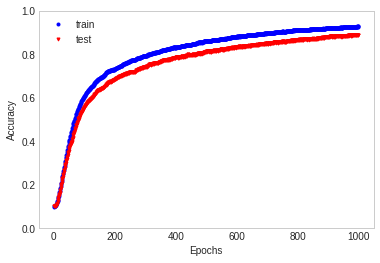

In [31]:
x = np.arange(len(model_1_train_acc_list))

plt.plot(x, model_1_train_acc_list, 'bo', label='train', markersize=3)
plt.plot(x, model_1_test_acc_list, 'rv', label='test', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(0, 1.0)
plt.legend()
plt.show()


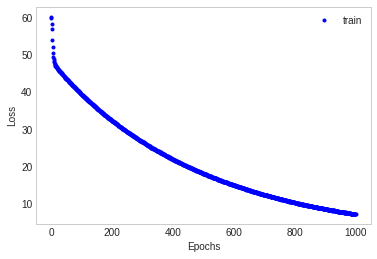

In [26]:
x = np.arange(len(model_1_train_loss_list))

plt.plot(x, model_1_train_loss_list, 'g--', label='train', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()


#모델 생성 및 학습 2
- 학습 데이터 수: 10,000
- Hidden Layers: 4  
  [100, 100, 100, 100]
- Optimizer: Adam
- Epochs: 1000
- Learning Rate: 1e-3 (0.001)
- Batch Size: 100
- Dropout: 0.5
- Batch Normalization: True
- Regularization: 0.15

In [19]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:10000]
x_test = x_test[:3000]

y_train = y_train[:10000]
y_test = y_test[:3000]

x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32) # flatten

x_train = x_train / .255
x_test = x_test / .255

y_train = np.eye(num_classes)[y_train]

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(10000, 784)
(10000, 10)
(3000, 784)
(3000,)


In [ ]:
epochs = 1000
learning_rate = 1e-3
batch_size = 100
train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

In [23]:
decay_lambda_2 = 0.15
model_2 = MyModel(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10, decay_lambda=decay_lambda, use_dropout=True, dropout_ratio=0.5, use_batchnorm=True)

optimizer = Adam(learning_rate)

model_2_train_loss_list = []
model_2_train_acc_list = []
model_2_test_acc_list = []


for epoch in range(epochs):
  batch_mask = np.random.choice(train_size, batch_size) # train_size중에서 batch_size 만큼 선택 미니배치 방법
  x_batch = x_train[batch_mask]
  y_batch = y_train[batch_mask]

  grads = model_2.gradient(x_batch, y_batch)
  optimizer.update(model_2.params, grads)

  loss = model_2.loss(x_batch, y_batch)
  model_2_train_loss_list.append(loss)

  train_acc = model_2.accuracy(x_train, y_train)
  test_acc = model_2.accuracy(x_test, y_test)
  model_2_train_acc_list.append(train_acc)
  model_2_test_acc_list.append(test_acc)

  if epoch % 50 == 0:
    print("[Model 2] Epoch: {}  Train Loss: {:.4f}  Train Accuracy: {:.4f}  Test Accuracy: {:.4f}".format(epoch+1, loss, train_acc, test_acc))

[Model 2] Epoch: 1  Train Loss: 47.1680  Train Accuracy: 0.1301  Test Accuracy: 0.1387
[Model 2] Epoch: 51  Train Loss: 2.2480  Train Accuracy: 0.6242  Test Accuracy: 0.5833
[Model 2] Epoch: 101  Train Loss: 2.0165  Train Accuracy: 0.7067  Test Accuracy: 0.6720
[Model 2] Epoch: 151  Train Loss: 2.1119  Train Accuracy: 0.6825  Test Accuracy: 0.6500
[Model 2] Epoch: 201  Train Loss: 1.9337  Train Accuracy: 0.7425  Test Accuracy: 0.6903
[Model 2] Epoch: 251  Train Loss: 2.1326  Train Accuracy: 0.7552  Test Accuracy: 0.7243
[Model 2] Epoch: 301  Train Loss: 2.1850  Train Accuracy: 0.7608  Test Accuracy: 0.6993
[Model 2] Epoch: 351  Train Loss: 2.0210  Train Accuracy: 0.7885  Test Accuracy: 0.7357
[Model 2] Epoch: 401  Train Loss: 2.3128  Train Accuracy: 0.7377  Test Accuracy: 0.6740
[Model 2] Epoch: 451  Train Loss: 2.1588  Train Accuracy: 0.8143  Test Accuracy: 0.7577
[Model 2] Epoch: 501  Train Loss: 2.1561  Train Accuracy: 0.8389  Test Accuracy: 0.7713
[Model 2] Epoch: 551  Train Loss: 

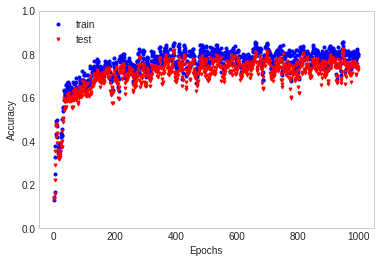

In [32]:
x = np.arange(len(model_2_train_acc_list))

plt.plot(x, model_2_train_acc_list, 'bo', label='train', markersize=3)
plt.plot(x, model_2_test_acc_list, 'rv', label='test', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(0, 1.0)
plt.legend()
plt.show()


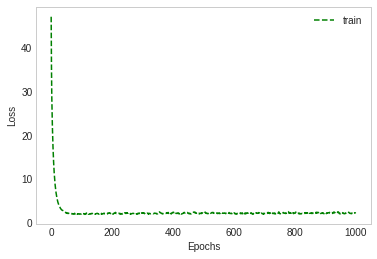

In [29]:
x = np.arange(len(model_2_train_loss_list))

plt.plot(x, model_2_train_loss_list, 'g--', label='train', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()


#모델 생성 및 학습 3
- 학습 데이터 수: 20,000
- Hidden Layers: 4  
  [500, 256, 100, 64]
- Optimizer: Adam
- Epochs: 1000
- Learning Rate: 1e-2 (0.01)
- Batch Size: 100
- Dropout: 0.5

In [27]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = 10

x_train = x_train[:20000]
x_test = x_test[:3000]

y_train = y_train[:20000]
y_test = y_test[:3000]

x_train, x_test = x_train.reshape(-1, 28*28).astype(np.float32), x_test.reshape(-1, 28*28).astype(np.float32) # flatten

x_train = x_train / .255
x_test = x_test / .255

y_train = np.eye(num_classes)[y_train]

In [30]:
epochs = 1000
learning_rate = 1e-2
batch_size = 100
train_size = x_train.shape[0]
iter_per_epoch = max(train_size / batch_size, 1)

model_3 = MyModel(input_size=784, hidden_size_list=[500, 256, 100, 64], output_size=10, decay_lambda=decay_lambda, use_dropout=True, dropout_ratio=0.5)

optimizer = Adam(learning_rate)

model_3_train_loss_list = []
model_3_train_acc_list = []
model_3_test_acc_list = []


for epoch in range(epochs):
  batch_mask = np.random.choice(train_size, batch_size) # train_size중에서 batch_size 만큼 선택 미니배치 방법
  x_batch = x_train[batch_mask]
  y_batch = y_train[batch_mask]

  grads = model_3.gradient(x_batch, y_batch)
  optimizer.update(model_3.params, grads)

  loss = model_3.loss(x_batch, y_batch)
  model_3_train_loss_list.append(loss)

  train_acc = model_3.accuracy(x_train, y_train)
  test_acc = model_3.accuracy(x_test, y_test)
  model_3_train_acc_list.append(train_acc)
  model_3_test_acc_list.append(test_acc)

  if epoch % 50 == 0:
    print("[Model 3] Epoch: {}  Train Loss: {:.4f}  Train Accuracy: {:.4f}  Test Accuracy: {:.4f}".format(epoch+1, loss, train_acc, test_acc))

[Model 3] Epoch: 1  Train Loss: 97.1328  Train Accuracy: 0.1989  Test Accuracy: 0.1903
[Model 3] Epoch: 51  Train Loss: 61.4455  Train Accuracy: 0.1138  Test Accuracy: 0.1143
[Model 3] Epoch: 101  Train Loss: 29.3926  Train Accuracy: 0.1139  Test Accuracy: 0.1140
[Model 3] Epoch: 151  Train Loss: 15.9131  Train Accuracy: 0.1277  Test Accuracy: 0.1290
[Model 3] Epoch: 201  Train Loss: 9.5658  Train Accuracy: 0.2171  Test Accuracy: 0.2087
[Model 3] Epoch: 251  Train Loss: 6.1174  Train Accuracy: 0.3433  Test Accuracy: 0.3337
[Model 3] Epoch: 301  Train Loss: 4.8158  Train Accuracy: 0.4475  Test Accuracy: 0.4307
[Model 3] Epoch: 351  Train Loss: 3.4269  Train Accuracy: 0.4886  Test Accuracy: 0.4670
[Model 3] Epoch: 401  Train Loss: 2.8324  Train Accuracy: 0.6030  Test Accuracy: 0.5793
[Model 3] Epoch: 451  Train Loss: 2.2746  Train Accuracy: 0.6753  Test Accuracy: 0.6423
[Model 3] Epoch: 501  Train Loss: 2.1238  Train Accuracy: 0.7038  Test Accuracy: 0.6557
[Model 3] Epoch: 551  Train Los

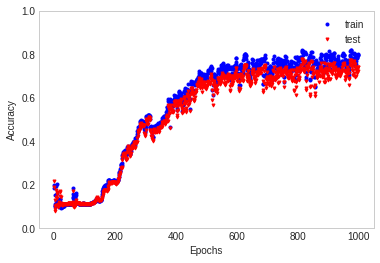

In [33]:
x = np.arange(len(model_3_train_acc_list))

plt.plot(x, model_3_train_acc_list, 'bo', label='train', markersize=3)
plt.plot(x, model_3_test_acc_list, 'rv', label='test', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(0, 1.0)
plt.legend()
plt.show()


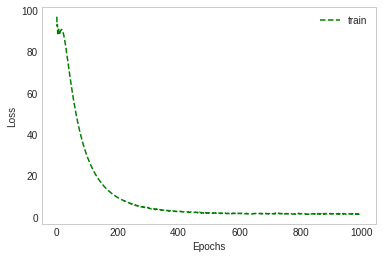

In [34]:
x = np.arange(len(model_3_train_loss_list))

plt.plot(x, model_3_train_loss_list, 'g--', label='train', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()


#3가지 모델 비교


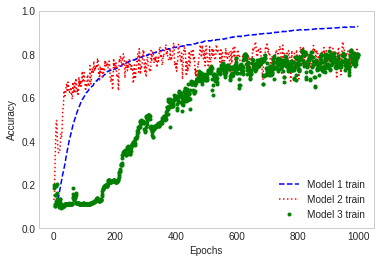

In [35]:
x = np.arange(len(model_3_train_acc_list))

plt.plot(x, model_1_train_acc_list, 'b--', label='Model 1 train', markersize=3)
plt.plot(x, model_2_train_acc_list, 'r:', label='Model 2 train', markersize=3)
plt.plot(x, model_3_train_acc_list, 'go', label='Model 3 train', markersize=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.ylim(0, 1.0)
plt.legend()
plt.show()


Model 2는 초반에 빠른 학습을 보임

Model 3는 느린 학습을 보임